# mlFlow

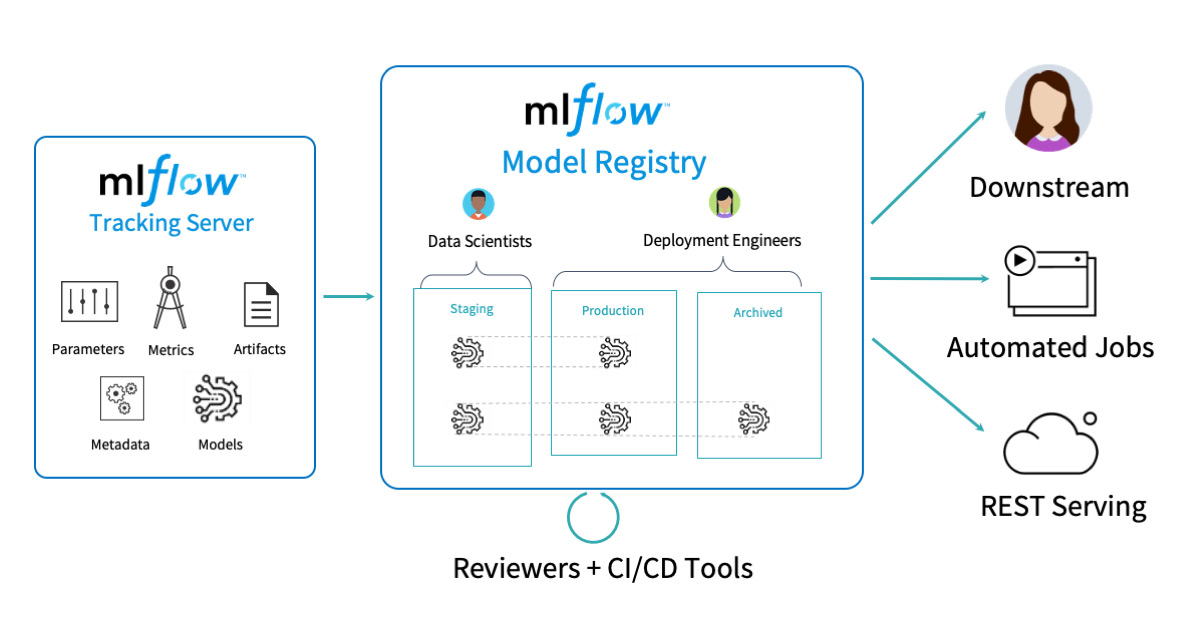

Fuente de la imagen: https://databricks.com/blog/2020/04/15/databricks-extends-mlflow-model-registry-with-enterprise-features.html

Ejemplo básico del uso de mlFlow, basado en sus tutoriales. Para más información consultar https://www.mlflow.org/

In [3]:
import os
import warnings
import sys

import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from urllib.parse import urlparse
import mlflow
import mlflow.sklearn

import logging

logging.basicConfig(level=logging.WARN)
logger = logging.getLogger(__name__)


def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    return rmse, mae, r2


warnings.filterwarnings("ignore")
np.random.seed(40)

# Read the wine-quality csv file from the URL
csv_url = (
    "http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv")
try:
    data = pd.read_csv(csv_url, sep=";")
except Exception as e:
    logger.exception(
        "Unable to download training & test CSV, check your internet connection. Error: %s", e)

# Split the data into training and test sets. (0.75, 0.25) split.
train, test = train_test_split(data)

# The predicted column is "quality" which is a scalar from [3, 9]
train_x = train.drop(["quality"], axis=1)
test_x = test.drop(["quality"], axis=1)
train_y = train[["quality"]]
test_y = test[["quality"]]

alpha =  0.5
l1_ratio =  0.5

with mlflow.start_run():
    lr = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=42)
    lr.fit(train_x, train_y)

    predicted_qualities = lr.predict(test_x)

    (rmse, mae, r2) = eval_metrics(test_y, predicted_qualities)
    
    print("Elasticnet model (alpha=%f, l1_ratio=%f):" % (alpha, l1_ratio))
    print("  RMSE: %s" % rmse)
    print("  MAE: %s" % mae)
    print("  R2: %s" % r2)

    mlflow.log_param("alpha", alpha)
    mlflow.log_param("l1_ratio", l1_ratio)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("mae", mae)

    tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

    # Model registry does not work with file store
    if tracking_url_type_store != "file":

        # Register the model
        # There are other ways to use the Model Registry, which depends on the use case,
        # please refer to the doc for more information:
        # https://mlflow.org/docs/latest/model-registry.html#api-workflow
        mlflow.sklearn.log_model(lr, "model", registered_model_name="ElasticnetWineModel")
    else:
        mlflow.sklearn.log_model(lr, "model")

Elasticnet model (alpha=0.500000, l1_ratio=0.500000):
  RMSE: 0.793164022927685
  MAE: 0.6271946374319586
  R2: 0.10862644997792625


In [4]:
#import mlflow
!mlflow ui

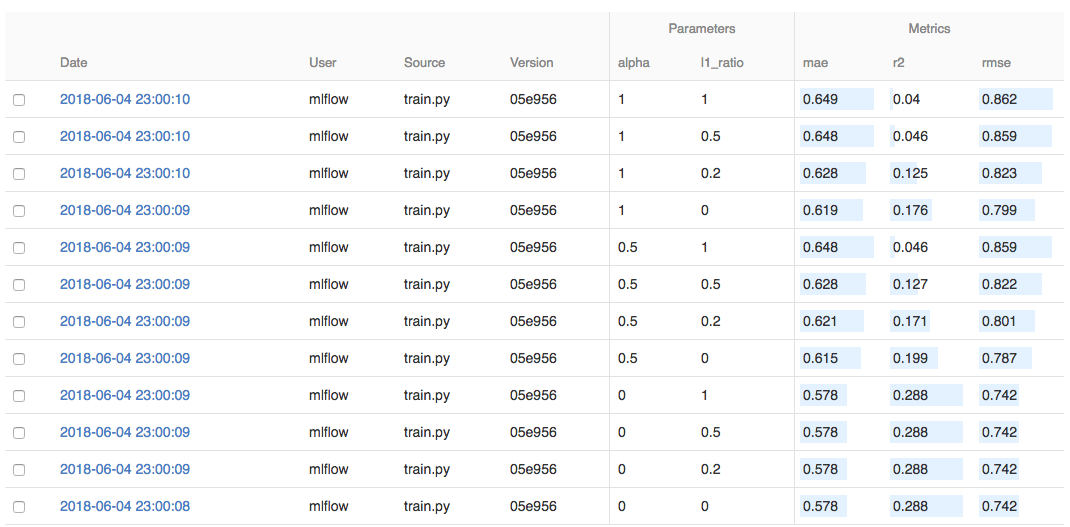

http://localhost:5000